<a href="https://colab.research.google.com/github/sravanisasu/Aganitha/blob/master/Binary_Classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Morlet Function**

In [171]:
# Morlet Function
def w_func(t):
  return torch.cos(1.75*t)* torch.exp(-(t**2))

**Required imports**

In [172]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os as os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import minmax_scale  
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

**Pre-process the data**

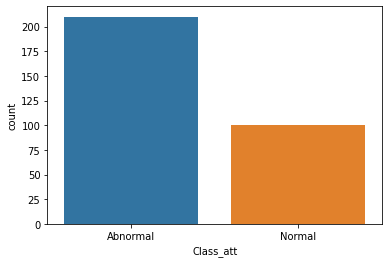

In [173]:
df = pd.read_csv("/content/Dataset_spine.csv")

# applying encoding for the output 0-normal and 1-abnormal
sns.countplot(x = 'Class_att', data=df)
df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}
df['Class_att'].replace(encode_map, inplace=True)

X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

# apply minmax scalar
X_train = minmax_scale(X_train)
X_test = minmax_scale(X_test)

**Initalise Hyper parameters**

In [174]:
nin = len(X.columns)
nhn = 10
non = 1

EPOCHS = 500
BATCH_SIZE = 16
lr = 0.01
mom = 0.999

**Function for train dataset**

In [175]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

**Function for test dataset**

In [176]:
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

**Load Dataset**

In [177]:
#train
train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

#test
test_data = testData(torch.FloatTensor(X_test))
test_loader = DataLoader(dataset=test_data, batch_size=1)

**Define Model**

In [178]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        self.fc1 = weight_norm(nn.Linear(nin, nhn, bias=False))
        self.fc2 = nn.Linear(nhn, non)
        self.a = nn.Parameter(torch.rand(nhn), requires_grad=True)
        self.b = nn.Parameter(torch.rand(nhn), requires_grad=True)
    def forward(self, x):
        t = (self.fc1(x)-self.b)/self.a
        vk = self.fc2(w_func(t))
        return vk

**Define accuracy function**

In [179]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

**Train the model**

In [180]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#define model
model = binaryClassification()
model.to(device)

#define loss function
criterion = nn.MSELoss()

#define optimiser
optimizer = optim.SGD(model.parameters(),  lr = lr, momentum=mom)

#train model
for e in range(1, EPOCHS+1):

  #check for checkpoint
  if os.path.exists("best.pt"):
      checkpoint = torch.load("best.pt")
      best_loss = checkpoint['loss']
  else:
      best_loss = 999999
  epoch_loss = 0
  epoch_acc = 0
  for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      optimizer.zero_grad()
      
      y_pred = model(X_batch)
      
      loss = criterion(y_pred, y_batch.unsqueeze(1))
      acc = binary_acc(y_pred, y_batch.unsqueeze(1))
      
      loss.backward()
      optimizer.step()
      
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  # update checkpoint with the best model
  if epoch_loss/len(train_loader) < best_loss:
      torch.save({
        'epoch': e,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss/len(train_loader),
        'acc' : epoch_acc/len(train_loader),
      }, "best.pt")      

  print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.31096 | Acc: 53.231
Epoch 002: | Loss: 0.28952 | Acc: 66.538
Epoch 003: | Loss: 0.23072 | Acc: 67.000
Epoch 004: | Loss: 0.25086 | Acc: 50.154
Epoch 005: | Loss: 0.23516 | Acc: 66.769
Epoch 006: | Loss: 0.22463 | Acc: 67.154
Epoch 007: | Loss: 0.24446 | Acc: 55.000
Epoch 008: | Loss: 0.21596 | Acc: 69.462
Epoch 009: | Loss: 0.22404 | Acc: 64.077
Epoch 010: | Loss: 0.23066 | Acc: 63.077
Epoch 011: | Loss: 0.24037 | Acc: 67.538
Epoch 012: | Loss: 0.21198 | Acc: 68.538
Epoch 013: | Loss: 0.22008 | Acc: 69.462
Epoch 014: | Loss: 0.19063 | Acc: 75.308
Epoch 015: | Loss: 0.19631 | Acc: 73.385
Epoch 016: | Loss: 0.21299 | Acc: 67.308
Epoch 017: | Loss: 0.19606 | Acc: 76.385
Epoch 018: | Loss: 0.21084 | Acc: 68.923
Epoch 019: | Loss: 0.19997 | Acc: 72.000
Epoch 020: | Loss: 0.19909 | Acc: 75.077
Epoch 021: | Loss: 0.18086 | Acc: 75.000
Epoch 022: | Loss: 0.18997 | Acc: 70.615
Epoch 023: | Loss: 0.22942 | Acc: 73.923
Epoch 024: | Loss: 0.18173 | Acc: 74.923
Epoch 025: | Los

**Evaluate the model and predict results**

In [181]:
y_pred_list = []

#load the best model from the saved checkpoint
if os.path.exists("best.pt"):
  checkpoint = torch.load("best.pt")
  model.load_state_dict(checkpoint['model_state_dict'])
  print('best epoch :',checkpoint["epoch"],'with loss :', checkpoint["loss"],'with accuracy :', checkpoint["acc"])

#evaluate the model and predict test output
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

#print the roc_auc_score
print(roc_auc_score(y_test, y_pred_list))

best epoch : 359 with loss : 0.08743722450274688 with accuracy : 90.15384615384616
0.7365591397849462
